# DATA VISUALISATION
If not present , create locally a 'Data' folder containing the datasets<br>

## Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [2]:
train_path = "Data/train.csv"
df = pd.read_csv(train_path, dtype={
    'PassengerId': str,
    'Survived': bool,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings / spouses aboard
    'Parch': 'uint8', # number of parents / children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'}) # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

## View Data

In [3]:
#view the data
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,False,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,False,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,False,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,True,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,True,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Assumptions and considerations about the available 12 fields:
* *PassengerId*, *Ticket*: unlikely to be useful because they can be considered as some sort of ids
* *Name*: unlikely to be useful because can be considered as some sort of id, but surname could be useful because of family relationships among the passengers
* *Pclass*: can be useful because it locates people on the ship based on the class fare
* *sex*: can be useful because of priorities for lifeboat rescue (female first)
* *age*: can be useful because of priorities for lifeboat rescue (young and elder first), adult are stronger than others and more likely to survive
* *SibSp*, Parch: can be useful because relatives are likely to help each others
* *Fare*: unlikely to be useful because its meaning it's likely to be included in 'Pclass'
* *Cabin*: can be useful in relation of where are the cabins are positioned on the ship
* *Embarked*: unlikely to be useful because all listed embark happened before the disaster

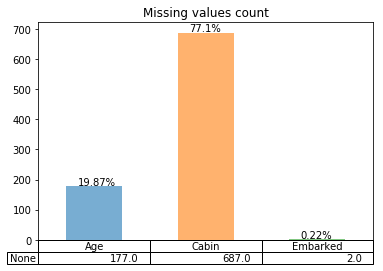

In [4]:
# Missing values

# number of rows
rows_length = df.shape[0]
# fields with missing value count
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind="bar", alpha=0.6, title="Missing values count", table=True)

ax.xaxis.set_visible(False) # hide x axis labels

# write percentage on top of each bar
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

*age*, *cabin*, *embarked* are the only fields with missing values:
* *cabin* being way more than 77% is likely to be dropped as information
* *age* needs some way to refill data
* *embarked* not really a problem since it has only 2 missing entries

In [5]:
#some statistics about the numerical data
df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Age is the only numerical feature with NaNs. <br>

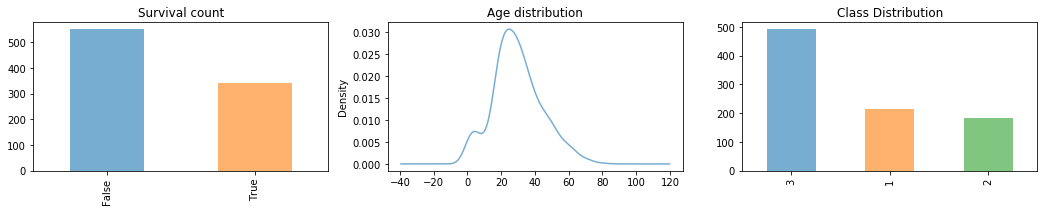

In [16]:
# specifies the parameters of our graphs
plt.figure(figsize=(18,6))

# plots a bar graph of those who surived vs those who did not.
ax1 = plt.subplot2grid((2,3), (0,0))
df.Survived.value_counts().plot(kind='bar', alpha=0.6, title="Survival count")

# plots a bar graph of the age distribution
ax2 = plt.subplot2grid((2,3), (0,1))
df.Age.plot(kind='kde', alpha=0.6, title="Age distribution")

# plots a bar graph of the class distribution
ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="bar", alpha=0.6, title="Class Distribution")

plt.show()